<a href="https://colab.research.google.com/github/trietp1253201581/KaggleCompetition/blob/main/cassava_leaf_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phân loại bệnh lá sắn

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [3]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [05:12<00:00, 22.9MB/s]
100% 5.76G/5.76G [05:12<00:00, 19.8MB/s]


In [4]:
from zipfile import ZipFile
with ZipFile('cassava-leaf-disease-classification.zip') as zip_ref:
    zip_ref.extractall('.')

In [6]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [11]:
import pandas as pd

In [12]:
train_df = pd.read_csv('train.csv')

In [13]:
train_df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [28]:
import shutil
folder_0 = 'train/0'
folder_1 = 'train/1'
folder_2 = 'train/2'
folder_3 = 'train/3'
folder_4 = 'train/4'

for folder in [folder_0, folder_1, folder_2, folder_3, folder_4]:
    os.makedirs(folder, exist_ok=True)

img_dir = 'train_images/'
for i in range(len(train_df)):
    if train_df.loc[i, 'label'] == 0:
        shutil.copy(img_dir + train_df.loc[i,'image_id'], folder_0)
    elif train_df.loc[i, 'label'] == 1:
        shutil.copy(img_dir + train_df.loc[i,'image_id'], folder_1)
    elif train_df.loc[i, 'label'] == 2:
        shutil.copy(img_dir + train_df.loc[i,'image_id'], folder_2)
    elif train_df.loc[i, 'label'] == 3:
        shutil.copy(img_dir + train_df.loc[i,'image_id'], folder_3)
    elif train_df.loc[i, 'label'] == 4:
        shutil.copy(img_dir + train_df.loc[i,'image_id'], folder_4)

In [128]:
train_ds = ImageFolder('train', transform=tt.Compose([
    tt.Resize([128,128]),
    tt.ToTensor()
]))

In [129]:
img, label = train_ds[0]
print(img)
print(label)

tensor([[[0.1412, 0.1569, 0.1412,  ..., 0.3255, 0.3490, 0.3529],
         [0.1216, 0.1333, 0.1333,  ..., 0.3176, 0.2431, 0.3098],
         [0.3333, 0.1922, 0.1412,  ..., 0.5451, 0.3961, 0.4275],
         ...,
         [0.0667, 0.0784, 0.1098,  ..., 0.3451, 0.3373, 0.2118],
         [0.0549, 0.0706, 0.1333,  ..., 0.2392, 0.2314, 0.2078],
         [0.0510, 0.0784, 0.1490,  ..., 0.2196, 0.2196, 0.2588]],

        [[0.3412, 0.3490, 0.3647,  ..., 0.3725, 0.4078, 0.4118],
         [0.3333, 0.3373, 0.3529,  ..., 0.3961, 0.2549, 0.3333],
         [0.4588, 0.3686, 0.3412,  ..., 0.7294, 0.5451, 0.5725],
         ...,
         [0.1961, 0.1922, 0.2118,  ..., 0.3098, 0.3176, 0.2549],
         [0.1882, 0.1882, 0.2157,  ..., 0.2392, 0.2157, 0.2471],
         [0.1843, 0.1882, 0.2196,  ..., 0.2980, 0.2784, 0.3098]],

        [[0.4078, 0.3804, 0.3490,  ..., 0.2000, 0.2157, 0.2196],
         [0.3490, 0.3647, 0.3686,  ..., 0.1333, 0.1333, 0.1373],
         [0.4157, 0.3294, 0.3137,  ..., 0.2745, 0.2235, 0.

In [130]:
batch_size = 8
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [131]:
val_size = int(len(train_ds) * 0.2)
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [132]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

In [133]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

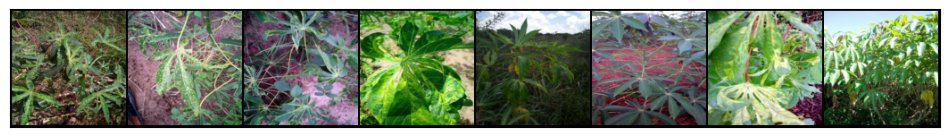

In [134]:
show_batch(train_dl)

In [135]:
import torch

In [136]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [137]:
device = get_default_device()
device

device(type='cuda')

In [138]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [139]:
import torch.nn as nn
import torch.nn.functional as F

In [140]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [141]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                    epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [142]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [149]:
class ResNet9(BaseModel):
    def __init__(self):
        super().__init__()
        self.prep = conv_block(3, 64)
        self.layer1 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.layer2 = conv_block(128, 256, pool=True)
        self.layer3 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(8192, 512),  # Adjust the input features to match the previous layer's output
                                        nn.ReLU(),
                                        nn.Linear(512, 5))

    def forward(self, xb):
        out = self.prep(xb)
        out = self.layer1(out)
        out = self.res1(out) + out
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [150]:
model = to_device(ResNet9(), device)
model

ResNet9(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [145]:
@torch.no_grad()
def evaluate(model, val_loader):
    torch.cuda.empty_cache()
    model.eval()
    outputs = []
    for batch in val_loader:
        batch = to_device(batch, device)  # Move each batch to GPU individually
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

In [146]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [147]:
def fit_one_cycle(epochs: int, max_lr: float, model: BaseModel,
                  train_dl: DataLoader, val_dl: DataLoader,
                  opt_func = torch.optim.SGD,
                  weight_decay = 0, grad_clip = None):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [151]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.6060396432876587, 'val_acc': 0.10280373692512512}]

In [152]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [153]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00280, train_loss: 1.3005, val_loss: 1.1863, val_acc: 0.6147
Epoch [1], last_lr: 0.00760, train_loss: 1.2020, val_loss: 1.1857, val_acc: 0.6147
Epoch [2], last_lr: 0.01000, train_loss: 1.1897, val_loss: 1.1978, val_acc: 0.6147


KeyboardInterrupt: 

In [154]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, strides=1, is_used_conv11=False):
        super().__init__()
        self.is_used_conv11 = is_used_conv11
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=1)
        if self.is_used_conv11:
            self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.is_used_conv11:
            y = self.conv3(x)
        else:
            y = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn(out)
        out = self.relu(out+y)
        out = self.conv4(out)
        return out

In [156]:
class ResNet18(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.res = nn.Sequential(
            # 2 start conv mapping
            ResidualBlock(in_channels=64, out_channels=64, strides=2),
            ResidualBlock(in_channels=64, out_channels=64, strides=2),
            # 3 conv mapping + idenity mapping
            ResidualBlock(in_channels=64, out_channels=128, strides=2, is_used_conv11=True),
            ResidualBlock(in_channels=128, out_channels=128, strides=2),
            ResidualBlock(in_channels=128, out_channels=256, strides=2, is_used_conv11=True),
            ResidualBlock(in_channels=256, out_channels=256, strides=2),
            ResidualBlock(in_channels=256, out_channels=512, strides=2, is_used_conv11=True),
            ResidualBlock(in_channels=512, out_channels=512, strides=2)
        )
        self.avg_pool = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.max_pool(out)
        out = self.res(out)
        out = self.avg_pool(out)
        out = self.fc(out)
        return out

In [163]:
model18 = to_device(ResNet18(5), device)
model18

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (res): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(64, 64, kernel_si

In [164]:
history = [evaluate(model18, val_dl)]
history

[{'val_loss': 1.622280478477478, 'val_acc': 0.05186915770173073}]

In [161]:
epochs = 3
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [165]:
%%time
history += fit_one_cycle(epochs, max_lr, model18, train_dl, val_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00994, train_loss: 1.2247, val_loss: 1.2016, val_acc: 0.6147
Epoch [1], last_lr: 0.00463, train_loss: 1.1926, val_loss: 1.2422, val_acc: 0.6147


KeyboardInterrupt: 